# Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply our graph ConvNet ([paper] & [code]), or any other, to your structured or unstructured data. For this example, we assume that we have $n$ samples $x_i \in \R^{d_x}$ arranged in a data matrix $$X = [x_1, ..., x_n]^T \in \R^{n \times d_x}.$$ Each sample $x_i$ is associated with a vector $y_i \in \R^{d_y}$ for a regression task or a label $y_i \in \{0,\ldots,C\}$ for a classification task.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

From there, we'll structure our data with a graph $\G = (\V, \E, A)$ where $\V$ is the set of $d_x = |\V|$ vertices, $\E$ is the set of edges and $A \in \R^{d_x \times d_x}$ is the adjacency matrix. That matrix represents the weight of each edge, i.e. $A_{i,j}$ is the weight of the edge connecting $v_i \in \V$ to $v_j \in \V$. The weights of that feature graph thus represent pairwise relationships between features $i$ and $j$. We call that regime **signal classification / regression**, as the samples $x_i$ to be classified or regressed are graph signals.

Other modelling possibilities include:
1. Using a data graph, i.e. an adjacency matrix $A \in \R^{n \times n}$ which represents pairwise relationships between samples $x_i \in \R^{d_x}$. The problem is here to predict a graph signal $y \in \R^{n \times d_y}$ given a graph characterized by $A$ and some graph signals $X \in \R^{n \times d_x}$. We call that regime **node classification / regression**, as we classify or regress nodes instead of signals.
2. Another problem of interest is whole graph classification, with or without signals on top. We'll call that third regime **graph classification / regression**. The problem here is to classify or regress a whole graph $A_i \in \R^{n \times n}$ (with or without an associated data matrix $X_i \in \R^{n \times d_x}$) into $y_i \in \R^{d_y}$. In case we have no signal, we can use a constant vector $X_i = 1_n$ of size $n$.

In [1]:
import sys
sys.path.append('/projects/nbhagwat/ADNI_prediction/code/cnn_graph') 
from lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import sys  
from sklearn import preprocessing
from sklearn import *
import pandas as pd
import seaborn as sns
import time

/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysi

# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

In [72]:
# Load Data

baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'

exp_name = 'Exp_101_ADNI2_traj_MMSE_tp_bl'
use_ct = True
var_tp = False
shuffle_labels = False # What's your performance with random labels. 
scale_data = False

exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'

with open(exp_setup_path, 'rb') as f:
    exp_setup = pickle.load(f, encoding='latin') 


#Check if loading the correct experimental setup
if exp_name != exp_setup['exp_name']:
    print('Incorrect exp_name. Selected:{}, Retrieved:{}'.format(exp_name, exp_setup['exp_name']))

else:
    print('exp_name: {}'.format(exp_name))
    
    df = exp_setup['df']
    kf = exp_setup['sKF']
    
    feat_cols = []    
        
    if var_tp:
        ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
        ct_cols_tp_rate = list(df.columns[pd.Series(df.columns).str.contains('CT_rate')])
        ct_cols = ct_cols_bl + ct_cols_tp_rate
    else:
        ct_cols = list(df.columns[pd.Series(df.columns).str.contains('CT')])

    feat_cols = ct_cols

    X_raw = np.array(df[feat_cols]) #Otherwise scaling and shifting will remain the same for next model. 
    y = np.array(df['traj']) 
    
    
    # Create list of all the fold-subsets (needed for parallelization)
    Sub_train_kf =[]
    Sub_test_kf = []
    X_train_kf = []
    X_test_kf = []
    y_train_kf = []
    y_test_kf = []    

    start_time = time.time()
    for train, test in kf:
        Sub_train_kf.append(df['PTID'].values[train]) 
        Sub_test_kf.append(df['PTID'].values[test]) 
        X_tr = X_raw[train]
        y_tr = y[train]
        X_te = X_raw[test]
        y_te = y[test]

        if scale_data:
            scaler = preprocessing.StandardScaler().fit(X_tr)
            X_tr = scaler.transform(X_tr)
            X_te = scaler.transform(X_te)
            
            
        X_train_kf.append(X_tr)
        y_train_kf.append(y_tr)

        # No need to resample test data
        X_test_kf.append(X_te)            
        y_test_kf.append(y_te)

exp_name: Exp_101_ADNI2_traj_MMSE_tp_bl


# 2 Graph

The second thing we need is a **graph between features**, i.e. an adjacency matrix $A \in \mathbb{R}^{d_x \times d_x}$.
Structuring data with graphs is very flexible: it can accomodate both structured and unstructured data.
1. **Structured data**.
    1. The data is structured by an Euclidean domain, e.g. $x_i$ represents an image, a sound or a video. We can use a classical ConvNet with 1D, 2D or 3D convolutions or a graph ConvNet with a line or grid graph (however losing the orientation).
    2. The data is structured by a graph, e.g. the data lies on a transportation, energy, brain or social network.
2. **Unstructured data**. We could use a fully connected network, but the learning and computational complexities are gonna be large. An alternative is to construct a sparse similarity graph between features (or between samples) and use a graph ConvNet, effectively structuring the data and drastically reducing the number of parameters through weight sharing. As for classical ConvNets, the number of parameters are independent of the input size.

There are many ways, supervised or unsupervised, to construct a graph given some data. And better the graph, better the performance ! For this example we'll define the adjacency matrix as a simple similarity measure between features. Below are the choices one has to make when constructing such a graph.
1. The distance function. We'll use the Euclidean distance $d_{ij} = \|x_i - x_j\|_2$.
2. The kernel. We'll use the Gaussian kernel $a_{ij} = \exp(d_{ij}^2 / \sigma^2)$.
3. The type of graph. We'll use a $k$ nearest neigbors (kNN) graph.

d = |V| = 78, k|V| < |E| = 2100
0.96532 0.0


/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


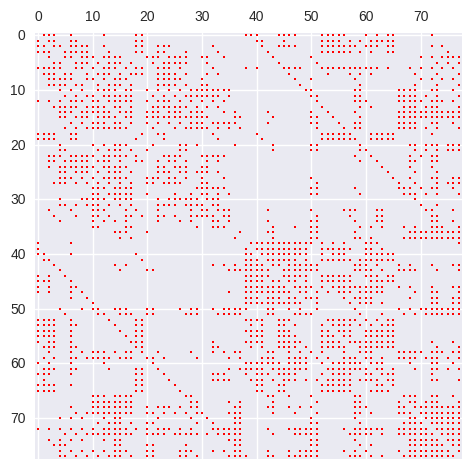

In [98]:
kf=1
train_subx = X_train_kf[kf].shape[0]
featx = X_train_kf[kf].shape[1]
train_valid_split = 0.9*train_subx
X_train = X_train_kf[kf][:train_valid_split,:]
y_train = y_train_kf[kf][:train_valid_split]
X_valid = X_train_kf[kf][train_valid_split:,:]
y_valid = y_train_kf[kf][train_valid_split:]

X_test = X_test_kf[kf]
y_test = y_test_kf[kf]

#dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='correlation')
dist, idx = graph.distance_scipy_spatial(X_train.T, k=20, metric='correlation')
A = graph.adjacency(dist, idx).astype(np.float32)

assert A.shape == (featx, featx)
print('d = |V| = {}, k|V| < |E| = {}'.format(featx, A.nnz))

print(np.max(A),np.min(A))
plt.spy(A, markersize=2, color='red');

# Set off-diagonal to 1 enforcing connections between timepoints.
rows, cols = np.indices((featx,featx))

for k in [-int(featx/2),int(featx/2)]:
    row_vals = np.diag(rows, k=k)
    col_vals = np.diag(cols, k=k)
    A[row_vals, col_vals]=1
    
plt.spy(A, markersize=2, color='red');

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

In [99]:
graphs, perm = coarsening.coarsen(A, levels=2, self_connections=False)

print(X_train.shape)
X_train = coarsening.perm_data(X_train, perm)
X_valid = coarsening.perm_data(X_valid, perm)
X_test = coarsening.perm_data(X_test, perm)
print(X_train.shape)


Layer 0: M_0 = |V| = 80 nodes (2 added),|E| = 1085 edges
Layer 1: M_1 = |V| = 40 nodes (0 added),|E| = 609 edges
Layer 2: M_2 = |V| = 20 nodes (0 added),|E| = 180 edges
(558, 78)
(558, 80)


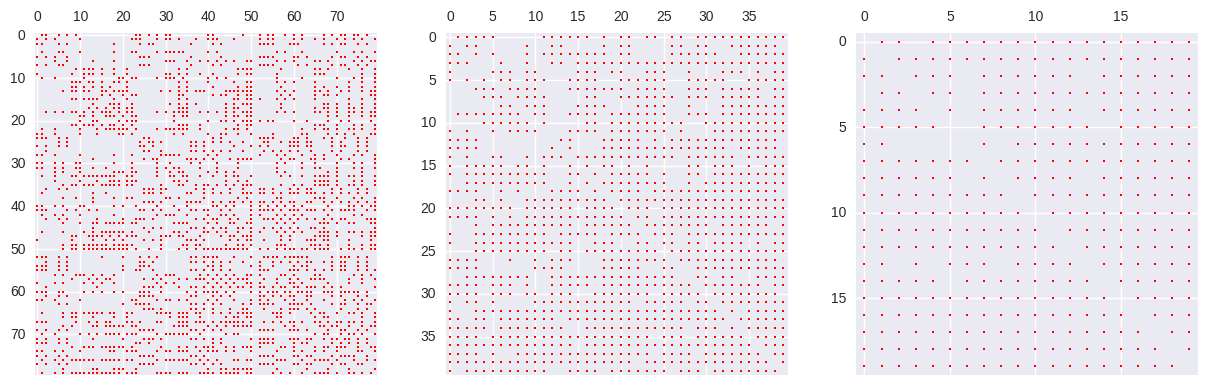

In [100]:
#Plot coarsened graphs
fig, ax1 = plt.subplots(figsize=(15, 5))
for g, A in enumerate(graphs):
    plt.subplot(1,len(graphs),g+1)
    plt.spy(A, markersize=2, color='red')

We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

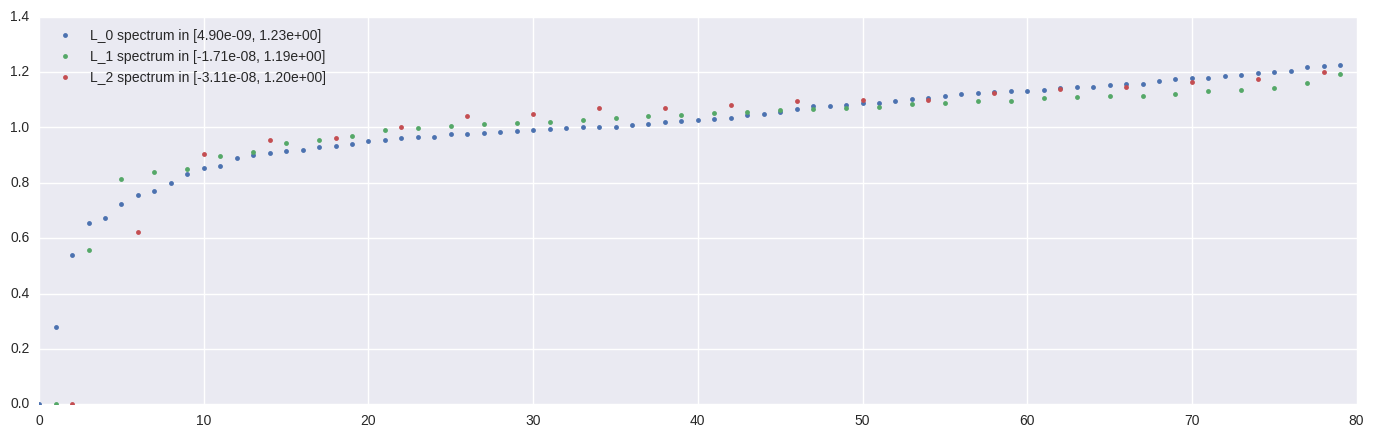

In [101]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [102]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 1000
params['batch_size']     = 100
params['eval_frequency'] = 100

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size
print(C)

# Architecture.
params['F']              = [16,16]  # Number of graph convolutional filters.
params['K']              = [5,5]  # Polynomial orders.
params['p']              = [2,2]    # Pooling sizes.
params['M']              = [16, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 1e-4
params['dropout']        = 1
params['learning_rate']  = 5e-5
params['decay_rate']     = 0.999
params['momentum']       = 0.8
params['decay_steps']    = X_train.shape[0]/params['batch_size']

2


In [103]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_test, y_test)

# Grid search doesn't work
#parameterGrid = {"learning_rate": [1e-3, 1e-4], "F": [[16,16],[32,32]]}
#utils.grid_search(params, parameterGrid, X_train, y_train, X_val, y_val, X_test, y_test, model)

NN architecture
  input: M_0 = 80
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 80 * 16 / 2 = 640
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 40 * 16 / 2 = 320
    weights: F_1 * F_2 * K_2 = 16 * 16 * 5 = 1280
    biases: F_2 = 16
  layer 3: fc1
    representation: M_3 = 16
    weights: M_2 * M_3 = 320 * 16 = 5120
    biases: M_3 = 16
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 16 * 2 = 32
    biases: M_4 = 2
step 100 / 5580 (epoch 17.92 / 1000):
  learning_rate = 4.92e-05, loss_average = 6.99e-01
  validation accuracy: 34.78 (24 / 69), f1 (weighted): 17.95, loss: 1.04e+00
  time: 2s (wall 1s)


/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 200 / 5580 (epoch 35.84 / 1000):
  learning_rate = 4.83e-05, loss_average = 6.88e-01
  validation accuracy: 65.22 (45 / 69), f1 (weighted): 51.49, loss: 1.02e+00
  time: 4s (wall 3s)
step 300 / 5580 (epoch 53.76 / 1000):
  learning_rate = 4.74e-05, loss_average = 6.80e-01
  validation accuracy: 65.22 (45 / 69), f1 (weighted): 51.49, loss: 1.01e+00
  time: 7s (wall 4s)
step 400 / 5580 (epoch 71.68 / 1000):
  learning_rate = 4.66e-05, loss_average = 6.74e-01
  validation accuracy: 65.22 (45 / 69), f1 (weighted): 51.49, loss: 9.98e-01
  time: 9s (wall 6s)
step 500 / 5580 (epoch 89.61 / 1000):
  learning_rate = 4.57e-05, loss_average = 6.70e-01
  validation accuracy: 65.22 (45 / 69), f1 (weighted): 51.49, loss: 9.89e-01
  time: 11s (wall 7s)
step 600 / 5580 (epoch 107.53 / 1000):
  learning_rate = 4.49e-05, loss_average = 6.65e-01
  validation accuracy: 65.22 (45 / 69), f1 (weighted): 51.49, loss: 9.82e-01
  time: 13s (wall 9s)
step 700 / 5580 (epoch 125.45 / 1000):
  learning_rate = 

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

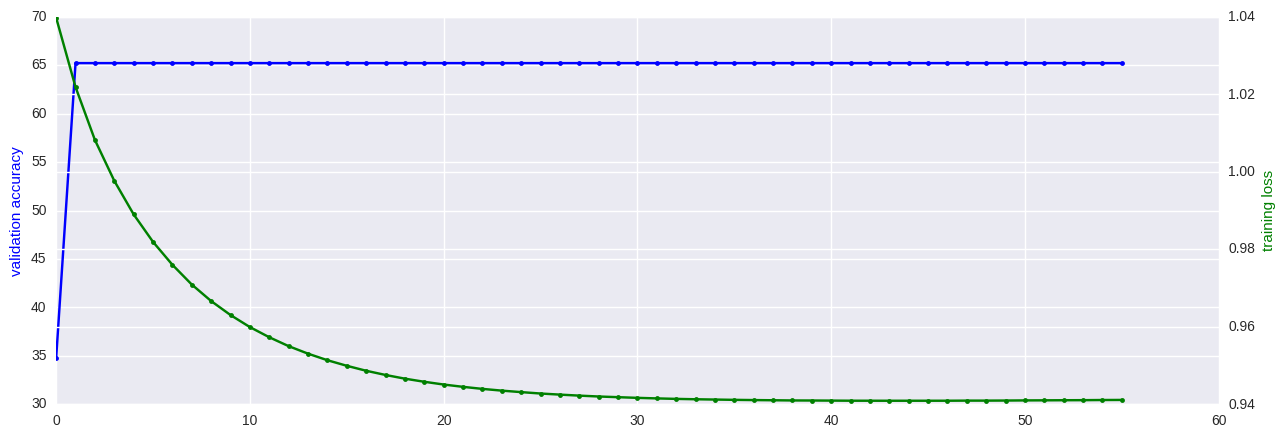

In [104]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [1196]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 13.57 ms


In [46]:
res = model.evaluate(X_train, y_train)
print('train:', res[0])
res = model.evaluate(X_valid, y_valid)
print('val:', res[0])
res = model.evaluate(X_test, y_test)
print('test:', res[0])


/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train: accuracy: 63.91 (356 / 557), f1 (weighted): 49.84, loss: 6.79e-01
time: 0s (wall 0s)
val: accuracy: 75.81 (47 / 62), f1 (weighted): 65.37, loss: 6.12e-01
time: 0s (wall 0s)
test: accuracy: 64.29 (45 / 70), f1 (weighted): 50.31, loss: 1.26e+00
time: 0s (wall 0s)


In [1198]:
# Print results for each pair of timepoints (bl-m06,bl-m12,bl-m24,m06-m12,m06-m24,m12-m24)
print(exp_setup['tp1_test'].shape)
print(exp_setup['X_L_test'].shape)
print(X_test.shape)
tp1_test = exp_setup['tp1_test']
tp_batch = 15
for tp_idx in range(0,90,tp_batch):    
    print(tp_idx, tp_idx+tp_batch, X_test[tp_idx:tp_idx+tp_batch,:].shape)
    res = model.evaluate(X_test[tp_idx:tp_idx+tp_batch,:], y_test[tp_idx:tp_idx+tp_batch])
    print(res[0])
  


(90,)
(90, 96)
(90, 160)
0 15 (15, 160)


/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: 53.33 (8 / 15), f1 (weighted): 37.10, loss: 5.13e+00
time: 0s (wall 0s)
15 30 (15, 160)
accuracy: 53.33 (8 / 15), f1 (weighted): 37.10, loss: 5.13e+00
time: 0s (wall 0s)
30 45 (15, 160)
accuracy: 53.33 (8 / 15), f1 (weighted): 37.10, loss: 5.13e+00
time: 0s (wall 0s)
45 60 (15, 160)
accuracy: 53.33 (8 / 15), f1 (weighted): 37.10, loss: 5.13e+00
time: 0s (wall 0s)
60 75 (15, 160)
accuracy: 53.33 (8 / 15), f1 (weighted): 37.10, loss: 5.13e+00
time: 0s (wall 0s)
75 90 (15, 160)
accuracy: 53.33 (8 / 15), f1 (weighted): 37.10, loss: 5.13e+00
time: 0s (wall 0s)


In [1203]:
# Get model weights and biases
var_name_weight_dict = {}
for i in (model.graph.get_collection('variables')):
    var_name = i.name.split(':')[0] 
    var_weights = model.get_var(var_name)
    print(var_name, var_weights.shape)
    var_name_weight_dict[var_name] = var_weights
    
    

conv1/weights (10, 20)
conv1/bias (1, 1, 20)
conv2/weights (40, 10)
conv2/bias (1, 1, 10)
fc1/weights (400, 8)
fc1/bias (8,)
logits/weights (8, 2)
logits/bias (2,)
loss/averages/loss/cross_entropy/Mean/ExponentialMovingAverage ()
loss/averages/loss/regularization/mul/ExponentialMovingAverage ()
loss/averages/loss/add/ExponentialMovingAverage ()
training/global_step ()
training/conv1/weights/Momentum (10, 20)
training/conv1/bias/Momentum (1, 1, 20)
training/conv2/weights/Momentum (40, 10)
training/conv2/bias/Momentum (1, 1, 10)
training/fc1/weights/Momentum (400, 8)
training/fc1/bias/Momentum (8,)
training/logits/weights/Momentum (8, 2)
training/logits/bias/Momentum (2,)


In [1201]:
conv1_W = model.get_var('conv1/weights')
conv2_W = model.get_var('conv2/weights')
fc1_W = model.get_var('fc1/weights')
#fc2_W = model.get_var('fc2/weights')
print(conv1_W.shape,conv2_W.shape,fc1_W.shape,fc2_W.shape)

(10, 20) (40, 10) (400, 8) (4, 4)


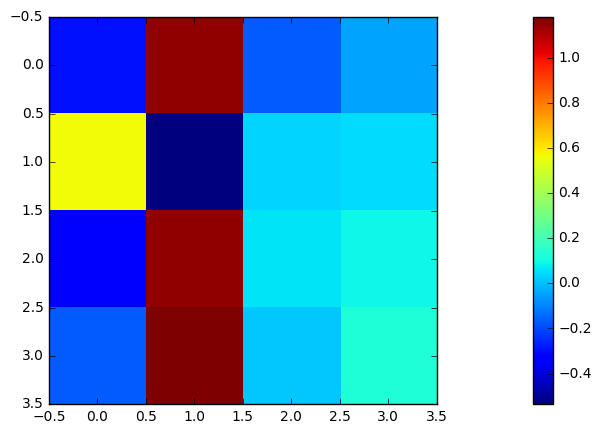

In [1202]:
fig, ax1 = plt.subplots(figsize=(25, 5))
plt.imshow(fc2_W.T, interpolation='nearest')
plt.colorbar()

In [1153]:
#model.graph.get_all_collection_keys()

'conv1/weights:0'